In [2]:
pip install prophet pandas scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


In [4]:
# Load CSV and check structure
df = pd.read_csv('SN_d_tot_V2.0.csv', sep=';', header=None)

# Check if the DataFrame has the expected number of columns
print(df.head())

# Rename columns (adjust if needed)
df.columns = ['Year', 'Month', 'Day', 'Date_Fraction', 'Sunspot_Count', 'Std_Deviation', 'Num_Observations', 'Indicator']

# Create 'Date' column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')

# Drop rows with invalid 'Date'
df = df.dropna(subset=['Date'])

# Filter necessary columns and drop missing sunspot values
df = df[['Date', 'Sunspot_Count']]
df = df[df['Sunspot_Count'] != -1]


      0  1  2         3  4    5  6  7
0  1818  1  1  1818.001 -1 -1.0  0  1
1  1818  1  2  1818.004 -1 -1.0  0  1
2  1818  1  3  1818.007 -1 -1.0  0  1
3  1818  1  4  1818.010 -1 -1.0  0  1
4  1818  1  5  1818.012 -1 -1.0  0  1


In [8]:
date_diffs = df['Date'].diff().dt.days.dropna()
unit = 'day' if date_diffs.max() <= 1 else 'month' if date_diffs.max() <= 31 else 'year'
print(f"Detected time unit: {unit}")


Detected time unit: year


In [10]:
# Prepare the DataFrame for Prophet
df_prophet = df.rename(columns={'Date': 'ds', 'Sunspot_Count': 'y'})

# Initialize Prophet model with parameters
model = Prophet(growth='linear')  # Change to 'linear' or 'flat' for testing
model.add_seasonality(name='custom_season', period=365.25, fourier_order=10)  # Adjust as needed

# Fit the model
model.fit(df_prophet)


21:22:47 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing


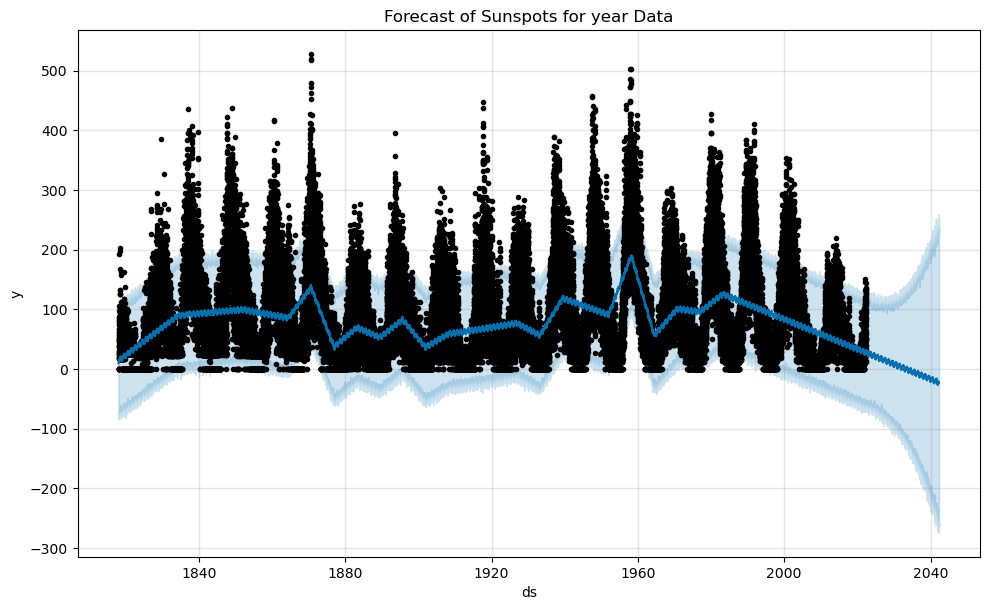

In [11]:
future_periods = {'day': 365, 'month': 9 * 30, 'year': 20 * 365}
future = model.make_future_dataframe(periods=future_periods[unit])

# Make predictions
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title(f"Forecast of Sunspots for {unit} Data")
plt.show()


In [14]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Compute metrics (use last X observations for comparison)
y_true = df_prophet['y'][-100:]  # Adjust slice based on prediction range
y_pred = forecast['yhat'][-100:]

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2 Score: {r2}")


MAE: 94.64854066599672
MAPE: 1.4163671597440288
R2 Score: -9.036444874326554


In [16]:
# Load monthly CSV file
monthly_df = pd.read_csv('SN_m_tot_V2.0.csv', sep=';', header=None)

# Rename columns for better readability
monthly_df.columns = ['Year', 'Month', 'Date_Fraction', 'Sunspot_Count', 'Std_Deviation', 'Num_Observations', 'Indicator']

# Create a 'Date' column from 'Year' and 'Month'
monthly_df['Date'] = pd.to_datetime(monthly_df[['Year', 'Month']].assign(Day=1), errors='coerce')

# Drop rows with invalid 'Date' and missing sunspot counts
monthly_df = monthly_df.dropna(subset=['Date'])
monthly_df = monthly_df[monthly_df['Sunspot_Count'] != -1]

# Keep only the 'Date' and 'Sunspot_Count' columns
monthly_df = monthly_df[['Date', 'Sunspot_Count']]

# Display the head of the DataFrame to verify
print(monthly_df.head())


        Date  Sunspot_Count
0 1749-01-01           96.7
1 1749-02-01          104.3
2 1749-03-01          116.7
3 1749-04-01           92.8
4 1749-05-01          141.7
